In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp '/content/drive/MyDrive/datasets/CRC_slides.tar.gz' .
!tar -xvzf 'CRC_slides.tar.gz'
data_dir = '/content/CRC_slides'

Streaming output truncated to the last 5000 lines.
CRC_slides/DEB/DEB-TCGA-ACMSDEFF.png
CRC_slides/DEB/DEB-TCGA-ACQQYLLS.png
CRC_slides/DEB/DEB-TCGA-ADCHTGEE.png
CRC_slides/DEB/DEB-TCGA-AFELDRPS.png
CRC_slides/DEB/DEB-TCGA-AFFMDFQV.png
CRC_slides/DEB/DEB-TCGA-AFQQTGKI.png
CRC_slides/DEB/DEB-TCGA-AGKPYMDE.png
CRC_slides/DEB/DEB-TCGA-AHDNMNIT.png
CRC_slides/DEB/DEB-TCGA-AHKLPKMS.png
CRC_slides/DEB/DEB-TCGA-AHQCDGMY.png
CRC_slides/DEB/DEB-TCGA-AIIGEWYP.png
CRC_slides/DEB/DEB-TCGA-ALLMHHRT.png
CRC_slides/DEB/DEB-TCGA-ALQTIPLF.png
CRC_slides/DEB/DEB-TCGA-APHIEAQK.png
CRC_slides/DEB/DEB-TCGA-AQGAYQML.png
CRC_slides/DEB/DEB-TCGA-ARIHITHS.png
CRC_slides/DEB/DEB-TCGA-ARRENSQH.png
CRC_slides/DEB/DEB-TCGA-ATLYPHGC.png
CRC_slides/DEB/DEB-TCGA-AVWDWIGH.png
CRC_slides/DEB/DEB-TCGA-AWICWARC.png
CRC_slides/DEB/DEB-TCGA-AYPDFRVW.png
CRC_slides/DEB/DEB-TCGA-CEVDKNMC.png
CRC_slides/DEB/DEB-TCGA-CHFTWKWR.png
CRC_slides/DEB/DEB-TCGA-CHRHVFKI.png
CRC_slides/DEB/DEB-TCGA-CKHTQHAC.png
CRC_slides/DEB/DEB-TCGA-

# Loading Dataset

In [4]:
def load_dataset(data_dir, train_pct = 0.6, val_pct = 0.2, test_pct=0.2, batch_size=64, img_size=(224, 224)):
  train_ds = keras.utils.image_dataset_from_directory(
      data_dir,
      batch_size=batch_size,
      image_size=img_size,
      validation_split=val_pct + test_pct,
      subset='training',
      seed=42)

  class_names = train_ds.class_names

  val_dataset = keras.utils.image_dataset_from_directory(
      data_dir,
      batch_size=batch_size,
      image_size=img_size,
      validation_split=val_pct + test_pct,
      subset='validation',
      seed=42
  )
  val_batches = tf.data.experimental.cardinality(val_dataset)
  test_batches = int(int(val_batches) * test_pct / (val_pct + test_pct))


  test_dataset = val_dataset.take(test_batches)
  val_dataset = val_dataset.skip(test_batches)

  devel_ds = train_ds.concatenate(val_dataset)

  return devel_ds, train_ds, val_dataset, test_dataset, class_names



In [5]:
devel_ds, train_ds, val_ds, test_ds, classes = load_dataset(data_dir)

Found 7180 files belonging to 9 classes.
Using 4308 files for training.
Found 7180 files belonging to 9 classes.
Using 2872 files for validation.


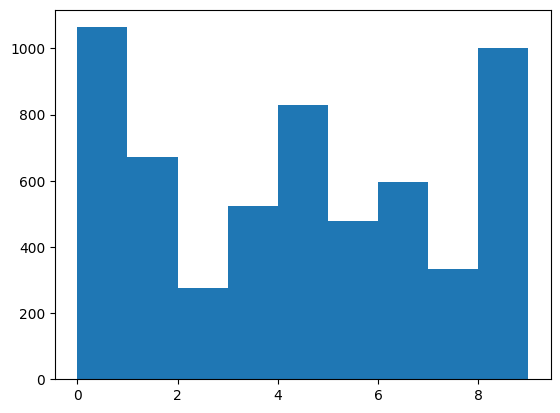

In [6]:
y = np.concatenate([y for x, y in devel_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

In [7]:
def confusion_matrix(model, test_ds):
  y_test = []
  y_pred = []
  for x_1, y_1 in test_ds:
    y_pred_1 = model.predict(x_1)
    y_test.append(y_1)
    y_pred.append(y_pred_1)
  y_true = np.concatenate(y_test)
  y_p = np.concatenate(y_pred)
  y_hat = tf.argmax(y_p, axis=1)
  cm = tf.math.confusion_matrix(y_true, y_hat)
  return cm, y_hat

# CNN 1

In [14]:
def cnn1(num_classes):
  model = keras.Sequential([
      keras.layers.Rescaling(1./255),
      keras.layers.Conv2D(8, 3, activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2,2)),
      keras.layers.Conv2D(16, 3, activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax'),
  ])
  return model


In [18]:
model = cnn1(len(classes))
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
callbacks = [early_stopping]

history = model.fit(train_ds, epochs=20, validation_data=val_ds, batch_size=64, callbacks=callbacks)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.1271 - loss: 3.6070 - val_accuracy: 0.1489 - val_loss: 2.1876
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.1499 - loss: 2.1867 - val_accuracy: 0.1667 - val_loss: 2.1762
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.1684 - loss: 2.1727 - val_accuracy: 0.1653 - val_loss: 2.1662
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.1682 - loss: 2.1620 - val_accuracy: 0.1680 - val_loss: 2.1569
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.1751 - loss: 2.1516 - val_accuracy: 0.1755 - val_loss: 2.1486
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.1920 - loss: 2.1428 - val_accuracy: 0.1721 - val_loss: 2.1403
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.1838 - loss: 2.1411 - val_accuracy: 0.1858 - val_loss: 2.1317
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.1933 - loss: 2.1318 - val_accuracy: 0.1810 - v

In [19]:
print(f'Train accuracy: {model.evaluate(train_ds)}')
print(f'Validation accuracy: {model.evaluate(val_ds)}')
print(f'Test accuracy: {model.evaluate(test_ds)}')

68/68 ━━━━━━━━━━━━━━━━━━━━ 51s 740ms/step - accuracy: 0.1944 - loss: 2.1347
Train accuracy: [2.1339590549468994, 0.18825441598892212]
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 727ms/step - accuracy: 0.1731 - loss: 2.1432
Validation accuracy: [2.139305353164673, 0.17896175384521484]
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 759ms/step - accuracy: 0.1774 - loss: 2.1374
Test accuracy: [2.1372830867767334, 0.18323864042758942]


In [21]:
cm, preds = confusion_matrix(model, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 729ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


In [22]:
print(cm)

tf.Tensor(
[[277   0   0   0   0   0   0   0   0]
 [171   0   0   0   0   0   0   0   0]
 [ 64   0   0   0   0   0   0   0   0]
 [113   0   0   0   0   0   0   0   0]
 [203   0   0   0   0   0   0   0   0]
 [117   0   0   0   0   0   0   0   0]
 [148   0   0   0   0   0   0   0   0]
 [ 82   0   0   0   0   0   0   0   0]
 [233   0   0   0   0   0   0   0   0]], shape=(9, 9), dtype=int32)


# CNN 2

In [8]:
def cnn2(num_classes):
  model = keras.Sequential([
      keras.layers.Rescaling(1./255),
      keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
      keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
      keras.layers.MaxPooling2D(pool_size=(4, 4)),
      keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
      keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
      keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
      keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
      keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Flatten(),
      keras.layers.Dense(1024, activation='relu'),
      keras.layers.Dense(num_classes, activation='softmax'),
  ])
  return model


In [9]:
model = cnn2(len(classes))
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
callbacks = [early_stopping]

history = model.fit(train_ds, epochs=20, validation_data=val_ds, batch_size=64, callbacks=callbacks)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 60s 554ms/step - accuracy: 0.1690 - loss: 2.5202 - val_accuracy: 0.1721 - val_loss: 2.0982
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - accuracy: 0.2583 - loss: 1.9334 - val_accuracy: 0.3784 - val_loss: 1.6018
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.4735 - loss: 1.3855 - val_accuracy: 0.5697 - val_loss: 1.2200
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - accuracy: 0.5716 - loss: 1.0993 - val_accuracy: 0.5587 - val_loss: 1.2589
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 330ms/step - accuracy: 0.6251 - loss: 1.0430 - val_accuracy: 0.5751 - val_loss: 1.1435
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 254ms/step - accuracy: 0.6135 - loss: 1.0033 - val_accuracy: 0.6469 - val_loss: 0.9244
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.6480 - loss: 0.9482 - val_accuracy: 0.5123 - val_loss: 1.1740
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.6201 - loss: 1.0143 - val_accu

In [10]:
print(f'Train accuracy: {model.evaluate(train_ds)}')
print(f'Validation accuracy: {model.evaluate(val_ds)}')
print(f'Test accuracy: {model.evaluate(test_ds)}')

68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.9129 - loss: 0.2370
Train accuracy: [0.2234407365322113, 0.9182915687561035]
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.8104 - loss: 0.6159
Validation accuracy: [0.6470435857772827, 0.8094262480735779]
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8064 - loss: 0.5792
Test accuracy: [0.5734195709228516, 0.8132102489471436]


In [11]:
cm, preds = confusion_matrix(model, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [12]:
print(cm)

tf.Tensor(
[[270   0   0   0   0   0   1   0   3]
 [  0 166   0   0   0   0   0   0   0]
 [  0   0  62   0   0   5   0   0   2]
 [  2   0   0  91   3   0   3   1  17]
 [ 25   0   1   2 163   0   5   3   3]
 [  0   0  10   0   0  89   0   2   6]
 [  1   0   0  11   2   1  63   8  56]
 [  0   0   7   8   2  14   3  35  21]
 [  1   0   1  10   2  12   7  11 197]], shape=(9, 9), dtype=int32)


# Efficient Net

In [13]:
model =  keras.applications.efficientnet.EfficientNetB0()

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_ds, epochs=5, validation_data=val_ds, batch_size=32)

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.7617 - loss: 1.4761 - val_accuracy: 0.8723 - val_loss: 0.7581
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 83s 385ms/step - accuracy: 0.9761 - loss: 0.0827 - val_accuracy: 0.9317 - val_loss: 0.3101
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - accuracy: 0.9891 - loss: 0.0399 - val_accuracy: 0.9768 - val_loss: 0.0735
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 335ms/step - accuracy: 0.9821 - loss: 0.0833 - val_accuracy: 0.9904 - val_loss: 0.0454
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 386ms/step - accuracy: 0.9892 - loss: 0.0305 - val_accuracy: 0.9904 - val_loss: 0.0290


In [14]:
print(f'Train accuracy: {model.evaluate(train_ds)}')
print(f'Validation accuracy: {model.evaluate(val_ds)}')
print(f'Test accuracy: {model.evaluate(test_ds)}')

68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.9985 - loss: 0.0043
Train accuracy: [0.003086089389398694, 0.9988393783569336]
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9879 - loss: 0.0435
Validation accuracy: [0.032187268137931824, 0.9904371500015259]
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9923 - loss: 0.0256
Test accuracy: [0.0258498378098011, 0.9907670617103577]


In [15]:
cm, preds = confusion_matrix(model, test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [16]:
print(cm)

tf.Tensor(
[[266   0   0   0   0   0   0   0   0]
 [  0 170   0   0   0   0   0   0   0]
 [  0   0  64   0   0   0   0   0   0]
 [  0   0   0 122   0   0   0   0   0]
 [  1   0   0   0 207   0   2   1   0]
 [  0   0   0   0   0 107   0   0   0]
 [  0   0   0   0   0   0 140   0   0]
 [  0   0   0   0   0   4   1  78   0]
 [  0   0   0   0   0   0   0   0 245]], shape=(9, 9), dtype=int32)
